# **ĐỒ ÁN: NHẬP MÔN KHOA HỌC DỮ LIỆU** #

### Nhóm 7 ###
|<div style="width:150px">MSSV</div>|<div style="width:290px">Tên</div>|
|---------- |:-------------:|
| 20120041  |  Trần Kim Bảo |
| 20120053  |    Nguyễn Thành Đạt   | 
| 20120071  | Nguyễn Thị Bích Hà |
| 20120113  | Lê Nguyên Khang |

## <font color='orange'> Import thư viện </font> ##

In [ ]:
!pip install scrapy
!pip install spider3

In [1]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import scrapy
from pandas.testing import assert_frame_equal # to compare two dataframes
# YOUR CODE HERE (OPTION) 
# Nếu cần các thư viện khác thì bạn có thể import thêm tại đây

## <font color='orange'> Mô tả trang web </font> ##

Trong đồ án này nhóm mình xin được giới thiệu đến mọi người danh sách phim hay nhất mọi thời đại *(Thời gian tính đến ngày 19/11/2022)* được trang IMDb tổng hợp. **IMDb** (<font color='blue'>https://www.imdb.com/</font>) là một trang cơ sở dữ liệu trực tuyến về điện ảnh thế giới, cung cấp thông tin về phim, diễn viên, đạo diễn, nhà làm phim,.. và tất cả những người, công ty trong lĩnh vực sản xuất phim, phim truyền hình và cả trò chơi video.

Những thông tin được thu thập tại website: <font color='blue'>https://www.imdb.com/list/ls006266261/</font>

### Tạo một project mới với scrapy ###

In [ ]:
!scrapy startproject film_crawler

In [2]:
cd film_crawler/film_crawler

/home/echkidieu/Desktop/YEAR3-SEM1/NM-KHDL/Project/week1/film_crawler/film_crawler


---

## <font color='orange'> Thu thập thông tin từ web </font> ##
**<h5>1. Thu thập url, id, votes, gross của các phim </h5>**

In [5]:
%%writefile spiders/collect_film_urls.py
import scrapy

class collect_film_url(scrapy.Spider):
  name='film_urls' 
  
  def start_requests(self):
    urls=['https://www.imdb.com/list/ls006266261/?sort=list_order,asc&st_dt=&mode=detail&page=1']
    self.page=1
    yield scrapy.Request(url=urls[0], callback=self.parse)
        
  def parse(self, response):
    stt=response.css('div.lister-list span.lister-item-index.unbold.text-primary::text').getall()
    id=response.css('div.lister-list img::attr(data-tconst)').getall()
    url=response.css('div.lister-list div.lister-item.mode-detail div.lister-item-image.ribbonize a::attr(href)').re(r'.*/title/.*\d{4,10}.')
    for i in range(len(stt)):
      yield{
        'STT': stt[i],
        'ID':id[i],
        'URL':url[i],
        'Votes':response.xpath(f'//*[@id="main"]/div/div[4]/div[3]/div[{i+1}]/div[2]/p[4]/span[2]/@data-value').get(),
        'Gross':response.xpath(f'//*[@id="main"]/div/div[4]/div[3]/div[{i+1}]/div[2]/p[4]/span[5]/@data-value').get()
      }
    if self.page<11:
      self.page+=1
      next_page_url=f'https://www.imdb.com/list/ls006266261/?sort=list_order,asc&st_dt=&mode=detail&page={self.page}'
      yield scrapy.Request(url=next_page_url, callback=self.parse)
      

Overwriting spiders/collect_film_urls.py


- **Xuất các thông tin đã thu thập ở trên ra file json**

In [ ]:
!scrapy crawl film_urls -o dataset/film_urls.json

In [7]:
%%writefile spiders/collect_data_films.py
import scrapy
import pandas as pd
import numpy as np
from selenium import webdriver

class collect_data_film(scrapy.Spider):
  name='data_film'
  def __init__(self):
    try:
      df = pd.read_json('./dataset/film_urls.json', encoding='utf-8-sig')
      self.urls=df['URL']
    except IOError:
      print("File not found")
  def start_requests(self):
    self.headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:48.0) Gecko/20100101 Firefox/48.0'}
    # CALOS
    # scrapy shell -s USER_AGENT='custom user agent' 'https://www.imdb.com/title/tt1321865/?ref_=ttls_li_tt'
    # JFK
    # scrapy shell -s USER_AGENT='custom user agent' 'https://www.imdb.com/title/tt0102138/?ref_=ttls_li_tt'
    # THE FIRM
    # scrapy shell -s USER_AGENT='custom user agent' 'https://www.imdb.com/title/tt0095158/?ref_=ttls_li_tt'
    for i in range(1000):
      next_page_url=f'https://www.imdb.com{self.urls[i]}?ref_=ttls_li_tt'
      yield scrapy.Request(url=next_page_url, callback=self.parse,headers=self.headers)

  def parse(self, response):

    # ID
    id_film=response.css('a.ipc-lockup-overlay.ipc-focusable::attr(href)').re(r'\w*\d{4,10}')[0]
    # Name
    name=response.css('h1[data-testid="hero-title-block__title"]::text').get()
    # Year release
    published_year=response.css("a[href*=releaseinfo]::text").re(r'\d{4}')[0]
    # Rate age
    age_rated=response.css("a[href*=certificates]::text").get()
    # Duration
    duration=response.css('div.ipc-metadata-list-item__content-container::text').getall()
    # Genres
    genres=response.css("a[href*=genres] span.ipc-chip__text::text").getall()
    
    # Director
    Director=set(response.xpath('//*[@id="__next"]/main/div/section[1]/section/div[3]').xpath(".//*[contains(text(),'Director')]").xpath('following-sibling::div/ul/li/a/text()').getall())
    # Writes
    Writers=set(response.xpath('//*[@id="__next"]/main/div/section[1]/section/div[3]').xpath(".//*[contains(text(),'Writer')]").xpath('following-sibling::div/ul/li/a/text()').getall())
    # Stars
    Stars=set(response.xpath('//*[@id="__next"]/main/div/section[1]/section/div[3]').xpath(".//*[contains(text(),'Star')]").xpath('following-sibling::div/ul/li/a/text()').getall())
    
    # Budget
    try:
      Budget=response.xpath(".//*[contains(text(),'Budget')]").xpath('following-sibling::div/ul/li/label/text()').re(r'^.?.*\s')[0]
    except:
      Budget=None

    #  IMDb rating
    IMDb_rating = response.css("span.sc-7ab21ed2-1::text").get()
    # Popularity
    popularity = response.css("div.sc-edc76a2-1::text").get()
    # User reviews
    user_reviews = response.css("span.three-Elements:contains(User\ reviews) span::text").get()
    # Critic reviews
    critic_reviews = response.css("span.three-Elements:contains(Critic\ reviews) span::text").get()
    # Metascore
    meta_score = response.css("span.score-meta::text").get()
    # Oscar wins
    wins = response.css("a[href*=awards]::text").get()
    
    yield {
      'ID':id_film,
      'Name':name,
      'Published Year':published_year,
      'Rated':age_rated,
      'Duration':duration,
      'Genres':genres,
      
      'Director':Director,
      'Writers':Writers,
      'Stars':Stars,
      'Budget (estimated)':Budget,
      
      "IMDb RATING": IMDb_rating,
      "Popularity" : popularity,
      "User reviews": user_reviews,
      "Critic reviews": critic_reviews,
      "Meta score": meta_score,
      "Wins": wins,
    }

Overwriting spiders/collect_data_films.py


In [ ]:
!scrapy crawl data_film -o dataset/data_film.json

---

## <font color='orange'> Khám phá dữ liệu </font> ##

<h4>1. Đọc dữ liệu</h4>

- <h5>Đọc file film_urls vào dataframe<h5>

In [3]:
df_url=pd.read_json('dataset/film_urls.json',encoding='utf-8-sig')
df_url.head()

,STT,ID,URL,Votes,Gross
0,1.,tt0068646,/title/tt0068646/,1849023,"134,966,411"
1,2.,tt0099685,/title/tt0099685/,1156616,"46,836,394"
2,3.,tt0110912,/title/tt0110912/,2042809,"107,928,762"
3,4.,tt0114814,/title/tt0114814/,1083153,"23,341,568"
4,5.,tt0078788,/title/tt0078788/,666748,"83,471,511"


- <h5>Đọc file data_film vào dataframe</h5>

In [4]:
df_film=pd.read_json('dataset/data_film.json',encoding='utf-8-sig')
df_film.head()

,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,Budget (estimated),IMDb RATING,Popularity,User reviews,Critic reviews,Meta score,Wins
0,tt0108052,Schindler's List,1993,R,"[3, , hours, , 15, , minutes]","[Biography, Drama, History]",[Steven Spielberg],"[Steven Zaillian, Thomas Keneally]","[Ben Kingsley, Ralph Fiennes, Liam Neeson]","$22,000,000",9.0,219,2.1K,175,94.0,Won 7 Oscars
1,tt0078788,Apocalypse Now,1979,R,"[2, , hours, , 27, , minutes]","[Drama, Mystery, War]",[Francis Ford Coppola],"[John Milius, Michael Herr, Francis Ford Coppola]","[Martin Sheen, Robert Duvall, Marlon Brando]","$31,500,000",8.5,307,1.3K,302,94.0,Won 2 Oscars
2,tt0137523,Fight Club,1999,R,"[2, , hours, , 19, , minutes]",[Drama],[David Fincher],"[Jim Uhls, Chuck Palahniuk]","[Meat Loaf, Edward Norton, Brad Pitt]","$63,000,000",8.8,139,4.3K,373,66.0,Nominated for 1 Oscar
3,tt0068646,The Godfather,1972,R,"[2, , hours, , 55, , minutes]","[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, James Caan, Marlon Brando]","$6,000,000",9.2,92,5.2K,193,100.0,Won 3 Oscars
4,tt0099685,Goodfellas,1990,R,"[2, , hours, , 25, , minutes]","[Biography, Crime, Drama]",[Martin Scorsese],"[Martin Scorsese, Nicholas Pileggi]","[Joe Pesci, Ray Liotta, Robert De Niro]","$25,000,000",8.7,194,1.5K,163,90.0,Won 1 Oscar


- <h5>Hợp dữ liệu lại</h5>

In [5]:
film_info_df=df_url.merge(df_film, on="ID", how="outer")
film_info_df.shape

(1000, 20)

In [6]:
film_info_df.head()

,STT,ID,URL,Votes,Gross,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,Budget (estimated),IMDb RATING,Popularity,User reviews,Critic reviews,Meta score,Wins
0,1.,tt0068646,/title/tt0068646/,1849023,"134,966,411",The Godfather,1972,R,"[2, , hours, , 55, , minutes]","[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, James Caan, Marlon Brando]","$6,000,000",9.2,92,5.2K,193,100.0,Won 3 Oscars
1,2.,tt0099685,/title/tt0099685/,1156616,"46,836,394",Goodfellas,1990,R,"[2, , hours, , 25, , minutes]","[Biography, Crime, Drama]",[Martin Scorsese],"[Martin Scorsese, Nicholas Pileggi]","[Joe Pesci, Ray Liotta, Robert De Niro]","$25,000,000",8.7,194,1.5K,163,90.0,Won 1 Oscar
2,3.,tt0110912,/title/tt0110912/,2042809,"107,928,762",Pulp Fiction,1994,R,"[2, , hours, , 34, , minutes]","[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Uma Thurman, John Travolta, Samuel L. Jackson]","$8,000,000",8.9,115,3.5K,304,94.0,Won 1 Oscar
3,4.,tt0114814,/title/tt0114814/,1083153,"23,341,568",The Usual Suspects,1995,R,"[1, , hour, , 46, , minutes]","[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Gabriel Byrne, Kevin Spacey]","$6,000,000",8.5,425,1.4K,154,77.0,Won 2 Oscars
4,5.,tt0078788,/title/tt0078788/,666748,"83,471,511",Apocalypse Now,1979,R,"[2, , hours, , 27, , minutes]","[Drama, Mystery, War]",[Francis Ford Coppola],"[John Milius, Michael Herr, Francis Ford Coppola]","[Martin Sheen, Robert Duvall, Marlon Brando]","$31,500,000",8.5,307,1.3K,302,94.0,Won 2 Oscars


- <h5>Ta thấy các cột như URL, Votes, Gross đứng đầu bảng thì rất khó quan sát, để dễ  quan sát và kiểm tra hơn, chúng ta cùng sắp xếp lại các cột nào</h5>

In [7]:
film_info_df=film_info_df[['STT','ID','Name','Published Year','Rated','Duration','Genres','Director','Writers','Stars','IMDb RATING'\
    ,'Budget (estimated)','Gross','Popularity','Votes','User reviews','Critic reviews','Meta score','Wins','URL']]

In [8]:
film_info_df.head()

,STT,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1.,tt0068646,The Godfather,1972,R,"[2, , hours, , 55, , minutes]","[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, James Caan, Marlon Brando]",9.2,"$6,000,000","134,966,411",92,1849023,5.2K,193,100.0,Won 3 Oscars,/title/tt0068646/
1,2.,tt0099685,Goodfellas,1990,R,"[2, , hours, , 25, , minutes]","[Biography, Crime, Drama]",[Martin Scorsese],"[Martin Scorsese, Nicholas Pileggi]","[Joe Pesci, Ray Liotta, Robert De Niro]",8.7,"$25,000,000","46,836,394",194,1156616,1.5K,163,90.0,Won 1 Oscar,/title/tt0099685/
2,3.,tt0110912,Pulp Fiction,1994,R,"[2, , hours, , 34, , minutes]","[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Uma Thurman, John Travolta, Samuel L. Jackson]",8.9,"$8,000,000","107,928,762",115,2042809,3.5K,304,94.0,Won 1 Oscar,/title/tt0110912/
3,4.,tt0114814,The Usual Suspects,1995,R,"[1, , hour, , 46, , minutes]","[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Gabriel Byrne, Kevin Spacey]",8.5,"$6,000,000","23,341,568",425,1083153,1.4K,154,77.0,Won 2 Oscars,/title/tt0114814/
4,5.,tt0078788,Apocalypse Now,1979,R,"[2, , hours, , 27, , minutes]","[Drama, Mystery, War]",[Francis Ford Coppola],"[John Milius, Michael Herr, Francis Ford Coppola]","[Martin Sheen, Robert Duvall, Marlon Brando]",8.5,"$31,500,000","83,471,511",307,666748,1.3K,302,94.0,Won 2 Oscars,/title/tt0078788/


In [9]:
film_info_df[film_info_df.Popularity.isnull()]

,STT,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
28,29.,tt1235166,A Prophet,2009,R,"[2, , hours, , 35, , minutes]","[Crime, Drama]",[Jacques Audiard],"[Thomas Bidegain, Abdel Raouf Dafri, Jacques A...","[Adel Bencherif, Tahar Rahim, Niels Arestrup]",7.8,"$13,000,000","2,084,637",None,99074,174,264,90.0,Nominated for 1 Oscar,/title/tt1235166/
83,84.,tt0310793,Bowling for Columbine,2002,R,"[2, , hours]","[Documentary, Crime, Drama]",[Michael Moore],[Michael Moore],"[Marilyn Manson, Charlton Heston, Michael Moore]",8.0,"$4,000,000","21,576,018",None,145155,897,208,72.0,Won 1 Oscar,/title/tt0310793/
125,126.,tt0475276,United 93,2006,R,"[1, , hour, , 51, , minutes]","[Action, Drama, History]",[Paul Greengrass],[Paul Greengrass],"[Liza Colón-Zayas, Olivia Thirlby, David Alan ...",7.6,"$15,000,000","31,567,134",None,107129,892,147,90.0,Nominated for 2 Oscars,/title/tt0475276/
127,128.,tt0120706,The General,1998,R,"[2, , hours, , 4, , minutes]","[Biography, Crime, Drama]",[John Boorman],"[John Boorman, Paul Williams]","[Brendan Gleeson, Sean McGinley, Adrian Dunbar]",7.2,None,"1,211,865",None,8861,51,54,81.0,Awards,/title/tt0120706/
131,132.,tt0114660,Things to Do in Denver When You're Dead,1995,R,"[1, , hour, , 55, , minutes]","[Crime, Drama, Thriller]",[Gary Fleder],[Scott Rosenberg],"[Christopher Walken, Christopher Lloyd, Andy G...",6.7,"$7,000,000","529,766",None,28177,165,45,46.0,Awards,/title/tt0114660/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,970.,tt0070707,Sleeper,1973,PG,"[1, , hour, , 29, , minutes]","[Comedy, Sci-Fi]",[Woody Allen],"[Woody Allen, Marshall Brickman]","[Woody Allen, John Beck, Diane Keaton]",7.1,"$2,000,000","2,905,334",None,43331,143,68,77.0,Awards,/title/tt0070707/
971,972.,tt2870648,Amy,2015,R,"[2, , hours, , 8, , minutes]","[Documentary, Biography, Music]",[Asif Kapadia],[],"[Mitch Winehouse, Amy Winehouse, Mark Ronson]",7.8,None,"8,413,144",None,52564,140,258,85.0,Won 1 Oscar,/title/tt2870648/
989,990.,tt1152758,Dear Zachary: A Letter to a Son About His Father,2008,Not Rated,"[1, , hour, , 35, , minutes]","[Documentary, Biography, Crime]",[Kurt Kuenne],[Kurt Kuenne],"[Andrew Bagby, Kurt Kuenne, David Bagby]",8.5,None,"20,834",None,37343,146,73,82.0,Awards,/title/tt1152758/
991,992.,tt5895028,13th,2016,TV-MA,"[1, , hour, , 40, , minutes]","[Documentary, Crime, History]",[Ava DuVernay],"[Spencer Averick, Ava DuVernay]","[Michelle Alexander, Cory Booker, Melina Abdul...",8.2,None,None,None,35831,120,101,83.0,Nominated for 1 Oscar,/title/tt5895028/


<h4>2. Bắt đầu khám phá dữ liệu</h4>

- <h5>Kiểm tra xem có dữ liệu trùng nhau không (<em>Ở đây ID mang tính định danh cho từng phim, ta sẽ kiểm tra xem thử có ID phim nào trùng nhau không</em>)</h5>

In [10]:
check_duplucate=set(film_info_df.ID.duplicated())
if True in check_duplucate:
    have_duplicated_rows = True
else:
    have_duplicated_rows = False

In [11]:
# TEST
assert have_duplicated_rows == False

<h4> Ý nghĩa mỗi dòng:</h4>

- Là thông tin chi tiết của các phim trong [top 1000 phim hay nhất mọi thời đại](https://www.imdb.com/list/ls006266261/), được [IMDb](https://www.imdb.com/?ref_=nv_home)  tổng hợp.


<h4>Ý nghĩa mỗi cột:</h4>

- Top: thể hiện vị thứ của phim trong danh sách
- ID: là duy nhất và mang tính định danh cho phim
- Name: tên của phim
- Published Year: Năm đầu tiên ra mắt phim
- Rated: 
- Duration: Thời gian phim
- Genres: Thể loại mà phim thuộc về
- Director: Đạo diễn sản xuất phim
- Writers: 
- Stars: Diễn viên nổi tiếng tham gia(ở đây nhóm chỉ lấy 1 vài người)
- IMDb RATING: Điểm đánh giá của IMDb về phim
- Budget (estimated): Kinh phí thực hiện phim (ước tính)
- Gross: Doanh thu của phim
- Popularity: Xếp hạng tổng quát
- Votes: Số lượt bình chọn
- User reviews: Số lượng nhận xét của người xem
- Critic reviews: Số lượng nhận xét của nhà phê bình
- Meta score:
- Wins: Giải mà phim đạt được trong các cuộc thi
- URL: địa chỉ truy cập vào trang web mô tả chi tiết của phim
- Votes: số lượt bình chọn cho phim
- Gross: Thu nhập của phim tính đến thời điểm hiện tại


<h4>Kiểm tra xem mỗi cột hiện đang có kiểu dữ liệu gì?</h4>

In [12]:
# YOUR CODE HERE

<h4>Khoảng biểu diễn của kiểu dữ liệu đó như thế nào?</h4>

In [13]:
# YOUR CODE HERE

<h4>Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp hay không?</h4>

In [14]:
# YOUR CODE HERE

<h4>Với mỗi cột, dữ liệu phân bố như thế nào?</h4>

In [15]:
# YOUR CODE HERE

---

## <font color='orange'> Tiền xử lý </font> ##

In [16]:
film_info_df.head()

,STT,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1.,tt0068646,The Godfather,1972,R,"[2, , hours, , 55, , minutes]","[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, James Caan, Marlon Brando]",9.2,"$6,000,000","134,966,411",92,1849023,5.2K,193,100.0,Won 3 Oscars,/title/tt0068646/
1,2.,tt0099685,Goodfellas,1990,R,"[2, , hours, , 25, , minutes]","[Biography, Crime, Drama]",[Martin Scorsese],"[Martin Scorsese, Nicholas Pileggi]","[Joe Pesci, Ray Liotta, Robert De Niro]",8.7,"$25,000,000","46,836,394",194,1156616,1.5K,163,90.0,Won 1 Oscar,/title/tt0099685/
2,3.,tt0110912,Pulp Fiction,1994,R,"[2, , hours, , 34, , minutes]","[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Uma Thurman, John Travolta, Samuel L. Jackson]",8.9,"$8,000,000","107,928,762",115,2042809,3.5K,304,94.0,Won 1 Oscar,/title/tt0110912/
3,4.,tt0114814,The Usual Suspects,1995,R,"[1, , hour, , 46, , minutes]","[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Gabriel Byrne, Kevin Spacey]",8.5,"$6,000,000","23,341,568",425,1083153,1.4K,154,77.0,Won 2 Oscars,/title/tt0114814/
4,5.,tt0078788,Apocalypse Now,1979,R,"[2, , hours, , 27, , minutes]","[Drama, Mystery, War]",[Francis Ford Coppola],"[John Milius, Michael Herr, Francis Ford Coppola]","[Martin Sheen, Robert Duvall, Marlon Brando]",8.5,"$31,500,000","83,471,511",307,666748,1.3K,302,94.0,Won 2 Oscars,/title/tt0078788/


- <h5>Ta thấy ở cột STT, Gross đang ở kiểu object, nhưng đúng là ở dạng numberic, ta thực hiện tiền xử lý về đúng kiểu dữ liệu</h5>

In [17]:
film_info_df.STT=film_info_df.STT.replace(',','',regex=True).replace('\.','',regex=True).astype(int)
film_info_df.Gross=film_info_df.Gross.replace([",",None],['',np.nan],regex=True).astype(float)

In [18]:
display(film_info_df)

,STT,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1,tt0068646,The Godfather,1972,R,"[2, , hours, , 55, , minutes]","[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, James Caan, Marlon Brando]",9.2,"$6,000,000",134966411.0,92,1849023,5.2K,193,100.0,Won 3 Oscars,/title/tt0068646/
1,2,tt0099685,Goodfellas,1990,R,"[2, , hours, , 25, , minutes]","[Biography, Crime, Drama]",[Martin Scorsese],"[Martin Scorsese, Nicholas Pileggi]","[Joe Pesci, Ray Liotta, Robert De Niro]",8.7,"$25,000,000",46836394.0,194,1156616,1.5K,163,90.0,Won 1 Oscar,/title/tt0099685/
2,3,tt0110912,Pulp Fiction,1994,R,"[2, , hours, , 34, , minutes]","[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Uma Thurman, John Travolta, Samuel L. Jackson]",8.9,"$8,000,000",107928762.0,115,2042809,3.5K,304,94.0,Won 1 Oscar,/title/tt0110912/
3,4,tt0114814,The Usual Suspects,1995,R,"[1, , hour, , 46, , minutes]","[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Gabriel Byrne, Kevin Spacey]",8.5,"$6,000,000",23341568.0,425,1083153,1.4K,154,77.0,Won 2 Oscars,/title/tt0114814/
4,5,tt0078788,Apocalypse Now,1979,R,"[2, , hours, , 27, , minutes]","[Drama, Mystery, War]",[Francis Ford Coppola],"[John Milius, Michael Herr, Francis Ford Coppola]","[Martin Sheen, Robert Duvall, Marlon Brando]",8.5,"$31,500,000",83471511.0,307,666748,1.3K,302,94.0,Won 2 Oscars,/title/tt0078788/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,tt0187738,Blade II,2002,R,"[1, , hour, , 57, , minutes]","[Action, Horror, Sci-Fi]",[Guillermo del Toro],"[Gene Colan, David S. Goyer, Marv Wolfman]","[Ron Perlman, Kris Kristofferson, Wesley Snipes]",6.7,"$54,000,000",82348319.0,"2,463",220651,613,221,52.0,Awards,/title/tt0187738/
996,997,tt0106856,Falling Down,1993,R,"[1, , hour, , 53, , minutes]","[Action, Crime, Drama]",[Joel Schumacher],[Ebbe Roe Smith],"[Michael Douglas, Robert Duvall, Barbara Hershey]",7.6,"$25,000,000",40903593.0,"1,362",191614,523,96,56.0,Awards,/title/tt0106856/
997,998,tt0120663,Eyes Wide Shut,1999,TV-MA,"[2, , hours, , 39, , minutes]","[Drama, Mystery, Thriller]",[Stanley Kubrick],"[Frederic Raphael, Arthur Schnitzler, Stanley ...","[Todd Field, Tom Cruise, Nicole Kidman]",7.5,"$65,000,000",55691208.0,206,342951,1.7K,284,68.0,Awards,/title/tt0120663/
998,999,tt0093437,The Lost Boys,1987,R,"[1, , hour, , 37, , minutes]","[Comedy, Horror]",[Joel Schumacher],"[Jeffrey Boam, Jan Fischer, James Jeremias]","[Jason Patric, Corey Haim, Dianne Wiest]",7.2,"$8,500,000",32222567.0,"1,207",145833,486,174,63.0,Awards,/title/tt0093437/


In [19]:
film_info_df.Rated.value_counts()

R            577
PG-13        179
PG           107
Not Rated     54
G             25
Approved      16
Passed        15
NC-17          8
Unrated        5
X              3
TV-14          3
GP             3
TV-MA          2
Name: Rated, dtype: int64

In [20]:
film_info_df[film_info_df['Rated'].isnull()]

,STT,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
286,287,tt0082096,The Boat,1981,None,"[2, , hours, , 29, , minutes]","[Drama, War]",[Wolfgang Petersen],"[Wolfgang Petersen, Lothar G. Buchheim]","[Klaus Wennemann, Jürgen Prochnow, Herbert Grö...",8.4,"DEM 32,000,000",11487676.0,"1,595",251700,568,112,86.0,Nominated for 6 Oscars,/title/tt0082096/
645,646,tt1242422,Celda 211,2009,None,"[1, , hour, , 53, , minutes]","[Action, Crime, Drama]",[Daniel Monzón],"[Daniel Monzón, Francisco Pérez Gandul, Jorge ...","[Luis Tosar, Alberto Ammann, Antonio Resines]",7.6,"€3,500,000",NaN,None,68172,None,None,NaN,Awards,/title/tt1242422/
675,676,tt0296042,Ichi the Killer,2001,None,"[2, , hours, , 9, , minutes]","[Action, Crime, Drama]",[Takashi Miike],"[Hideo Yamamoto, Sakichi Sato]","[Nao Ômori, Tadanobu Asano, Shin'ya Tsukamoto]",7.0,"$1,400,000",20285.0,None,56875,327,109,55.0,Awards,/title/tt0296042/


In [21]:
film_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   STT                 1000 non-null   int64  
 1   ID                  1000 non-null   object 
 2   Name                1000 non-null   object 
 3   Published Year      1000 non-null   int64  
 4   Rated               997 non-null    object 
 5   Duration            1000 non-null   object 
 6   Genres              1000 non-null   object 
 7   Director            1000 non-null   object 
 8   Writers             1000 non-null   object 
 9   Stars               1000 non-null   object 
 10  IMDb RATING         1000 non-null   float64
 11  Budget (estimated)  895 non-null    object 
 12  Gross               937 non-null    float64
 13  Popularity          782 non-null    object 
 14  Votes               1000 non-null   int64  
 15  User reviews        963 non-null    object 
 16  Critic 

---

## <font color='orange'> Câu hỏi đặt ra </font> ##

<h2>Câu 1:

- Phân tích trong 10 năm để tìm ra thể loại phim được yêu thích trong mỗi khoảng thời gian.
- Tương quan giữa các thể loại (genre) với doanh thu, độ nổi tiếng, các thành tựu đạt được
</h2>

<h3>Bước 1: Thống kê số lượng phim theo thập niên</h3>

In [22]:
film_info_df.head()

,STT,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1,tt0068646,The Godfather,1972,R,"[2, , hours, , 55, , minutes]","[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, James Caan, Marlon Brando]",9.2,"$6,000,000",134966411.0,92,1849023,5.2K,193,100.0,Won 3 Oscars,/title/tt0068646/
1,2,tt0099685,Goodfellas,1990,R,"[2, , hours, , 25, , minutes]","[Biography, Crime, Drama]",[Martin Scorsese],"[Martin Scorsese, Nicholas Pileggi]","[Joe Pesci, Ray Liotta, Robert De Niro]",8.7,"$25,000,000",46836394.0,194,1156616,1.5K,163,90.0,Won 1 Oscar,/title/tt0099685/
2,3,tt0110912,Pulp Fiction,1994,R,"[2, , hours, , 34, , minutes]","[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Uma Thurman, John Travolta, Samuel L. Jackson]",8.9,"$8,000,000",107928762.0,115,2042809,3.5K,304,94.0,Won 1 Oscar,/title/tt0110912/
3,4,tt0114814,The Usual Suspects,1995,R,"[1, , hour, , 46, , minutes]","[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Gabriel Byrne, Kevin Spacey]",8.5,"$6,000,000",23341568.0,425,1083153,1.4K,154,77.0,Won 2 Oscars,/title/tt0114814/
4,5,tt0078788,Apocalypse Now,1979,R,"[2, , hours, , 27, , minutes]","[Drama, Mystery, War]",[Francis Ford Coppola],"[John Milius, Michael Herr, Francis Ford Coppola]","[Martin Sheen, Robert Duvall, Marlon Brando]",8.5,"$31,500,000",83471511.0,307,666748,1.3K,302,94.0,Won 2 Oscars,/title/tt0078788/


<h5>Kiểm tra xem thử có phim nào không có năm ra mắt không?</h5>

In [23]:
film_info_df['Published Year'].isnull().any()

False

In [24]:
film_info_df['Published Year'].unique()

array([1972, 1990, 1994, 1995, 1979, 1996, 1999, 1993, 1997, 1992, 1975,
       1976, 1985, 1974, 2008, 1983, 2001, 1986, 1998, 1980, 2009, 2006,
       2002, 1984, 1973, 2000, 1981, 1988, 1942, 2010, 1987, 2005, 1971,
       2011, 1982, 1941, 2004, 2003, 1991, 1989, 2012, 1957, 1964, 2007,
       1946, 1977, 1966, 2013, 1978, 1969, 1967, 1939, 1954, 1968, 1960,
       2018, 2019, 1962, 1961, 2014, 2015, 2016, 1949, 1959, 1970, 2017,
       1955, 1950, 1956, 1963, 1958, 1940, 1948, 1965, 1938, 2020, 1952,
       1944, 1933, 1934, 1947])

<h5>Chia khoảng các phim theo cụm 10 năm</h5>

In [25]:
def decade(vl):
       return int(np.floor(vl/10)*10)

film_info_df.insert(4,"Decade",film_info_df['Published Year'].apply(decade),True)

In [26]:
film_info_df.head()

,STT,ID,Name,Published Year,Decade,Rated,Duration,Genres,Director,Writers,...,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1,tt0068646,The Godfather,1972,1970,R,"[2, , hours, , 55, , minutes]","[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]",...,9.2,"$6,000,000",134966411.0,92,1849023,5.2K,193,100.0,Won 3 Oscars,/title/tt0068646/
1,2,tt0099685,Goodfellas,1990,1990,R,"[2, , hours, , 25, , minutes]","[Biography, Crime, Drama]",[Martin Scorsese],"[Martin Scorsese, Nicholas Pileggi]",...,8.7,"$25,000,000",46836394.0,194,1156616,1.5K,163,90.0,Won 1 Oscar,/title/tt0099685/
2,3,tt0110912,Pulp Fiction,1994,1990,R,"[2, , hours, , 34, , minutes]","[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]",...,8.9,"$8,000,000",107928762.0,115,2042809,3.5K,304,94.0,Won 1 Oscar,/title/tt0110912/
3,4,tt0114814,The Usual Suspects,1995,1990,R,"[1, , hour, , 46, , minutes]","[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],...,8.5,"$6,000,000",23341568.0,425,1083153,1.4K,154,77.0,Won 2 Oscars,/title/tt0114814/
4,5,tt0078788,Apocalypse Now,1979,1970,R,"[2, , hours, , 27, , minutes]","[Drama, Mystery, War]",[Francis Ford Coppola],"[John Milius, Michael Herr, Francis Ford Coppola]",...,8.5,"$31,500,000",83471511.0,307,666748,1.3K,302,94.0,Won 2 Oscars,/title/tt0078788/


<h5>Cùng vẽ biểu đồ  xem số lượng phim thay đổi thế nào giữa các thập kỉ nào</h5>

In [27]:
film_decade=film_info_df.Decade.value_counts().sort_index()
film_decade

1930      6
1940     16
1950     19
1960     39
1970     76
1980    124
1990    215
2000    282
2010    222
2020      1
Name: Decade, dtype: int64

In [28]:
film_info_df[film_info_df.Decade==2020]

,STT,ID,Name,Published Year,Decade,Rated,Duration,Genres,Director,Writers,...,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
774,775,tt6723592,Tenet,2020,2020,PG-13,"[2, , hours, , 30, , minutes]","[Action, Sci-Fi, Thriller]",[Christopher Nolan],[Christopher Nolan],...,7.3,"$205,000,000",58456624.0,242,501780,5.5K,510,69.0,Won 1 Oscar,/title/tt6723592/


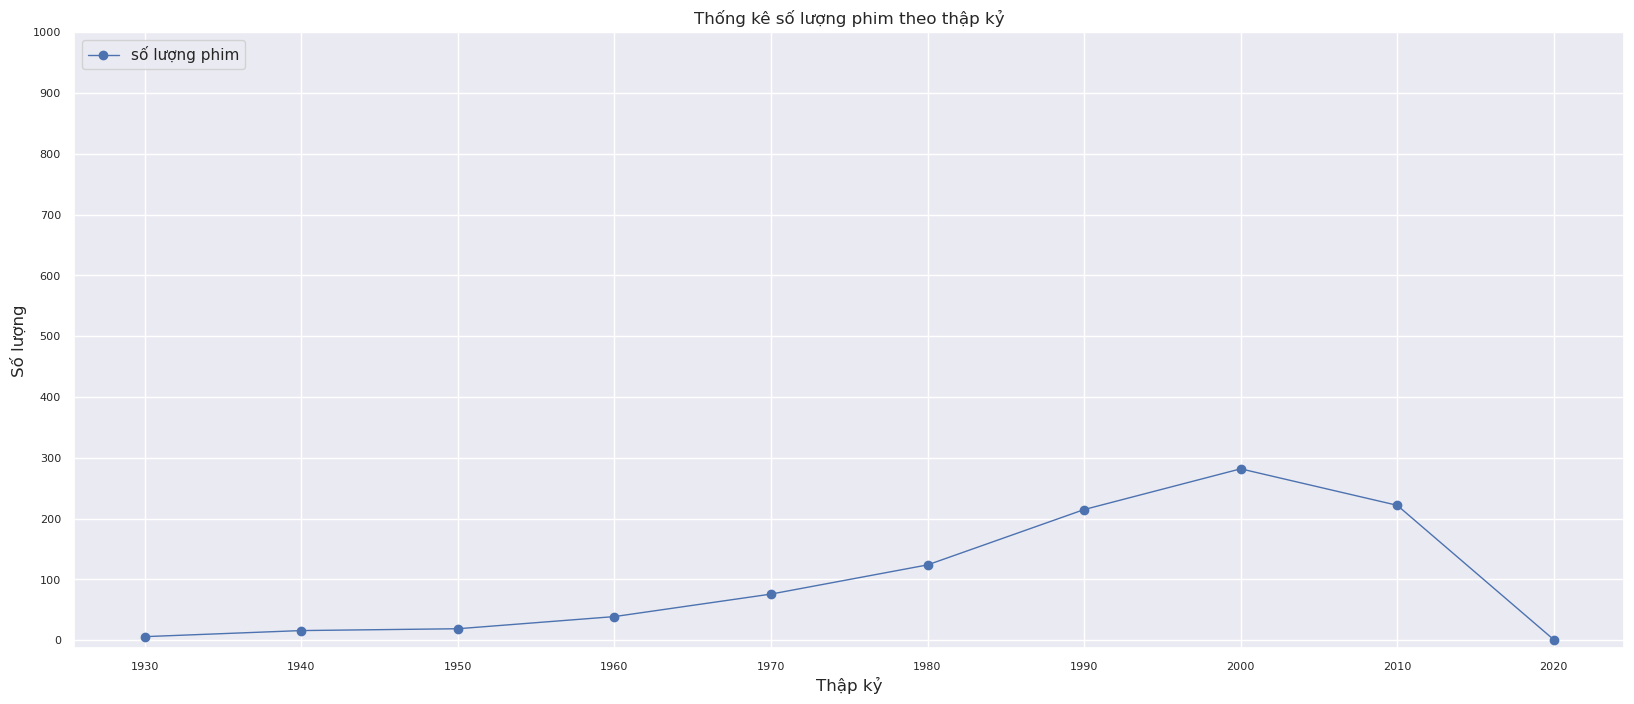

In [29]:

fig =plt.subplots(figsize=(20,8))

decade=np.array(film_decade.keys())
num_film=np.array(film_decade.values)

plt.plot(decade,num_film,marker='o',linestyle='-',linewidth=1,label='số lượng phim')
plt.xlabel('Thập kỷ')
plt.ylabel('Số lượng')
plt.title('Thống kê số lượng phim theo thập kỷ')
plt.xticks(decade,size=8)
plt.yticks(range(0,1001,100),size=8)
plt.legend(loc='upper left')
plt.show()

<h4>Nhận xét:</h4>

- Khi thực hiện đồ án, danh sách tổng hợp cập nhật lần gần nhất là 12/11/2021. Và với tình hình dịch bệnh các năm 2020, 2021 ở trên khắp thế giới, nên ta có thể thấy chỉ có 1 phim [Tenet](https://www.imdb.com/title/tt6723592/) là nằm trong [top 1000 phim](https://www.imdb.com/list/ls006266261/).<br>

- Và ta cũng có thể thấy được sự thay đổi rõ rệt về số lượng phim lọt top từ thập niên 1930 đến thập niên 2000 (tăng dần), tuy nhiên có 1 sự sụt giảm vào thập niên 2010 lúc công nghệ làm phim phát triển hơn hắn những thập niên trước (liệu rằng có yếu tố nào tác động đằng sau, chúng ta sẽ cố trả lời nó vào những phần sau nhé).


<h3>Bước 2: Thống kê số lượng phim theo thể loại</h3>

<h5>Tiếp tục chia ra xem những thể loại nào nhiều nhất nhé</h5>

In [30]:
film_info_df.Genres.explode().unique()

array(['Crime', 'Drama', 'Biography', 'Mystery', 'War', 'History',
       'Thriller', 'Adventure', 'Comedy', 'Sci-Fi', 'Action', 'Sport',
       'Romance', 'Animation', 'Horror', 'Fantasy', 'Western', 'Family',
       'Documentary', 'Music', 'Film-Noir', 'Musical'], dtype=object)


<h4>Ở đây, ta thấy hơi lạ sao lại có 2 thể loại Music và Musical, liệu dữ liệu có bị trùng hay gì không?</h4>


<h4>Câu trả lời là <b>không</b> nhé:</h4>

- Music: thể loại có liên quan đến âm nhạc ví dụ như một câu chuyện về một bản nhạc, hay đại loại như vậy.</br>
- Musical: thể loại nhạc kịch, tràn đầy những bản nhạc, kết hợp với những điệu nhảy cuốn hút người xem.</br>

[Chi tiết](https://help.imdb.com/article/contribution/titles/genres/GZDRMS6R742JRGAG#)


In [31]:
film_genre=film_info_df.Genres.explode().value_counts()
film_genre

Drama          573
Crime          293
Comedy         279
Action         254
Thriller       191
Adventure      181
Mystery        117
Biography      106
Horror          93
Romance         92
Sci-Fi          91
Fantasy         56
Documentary     50
Animation       34
History         34
Music           31
War             24
Sport           23
Family          23
Western         17
Film-Noir        8
Musical          6
Name: Genres, dtype: int64

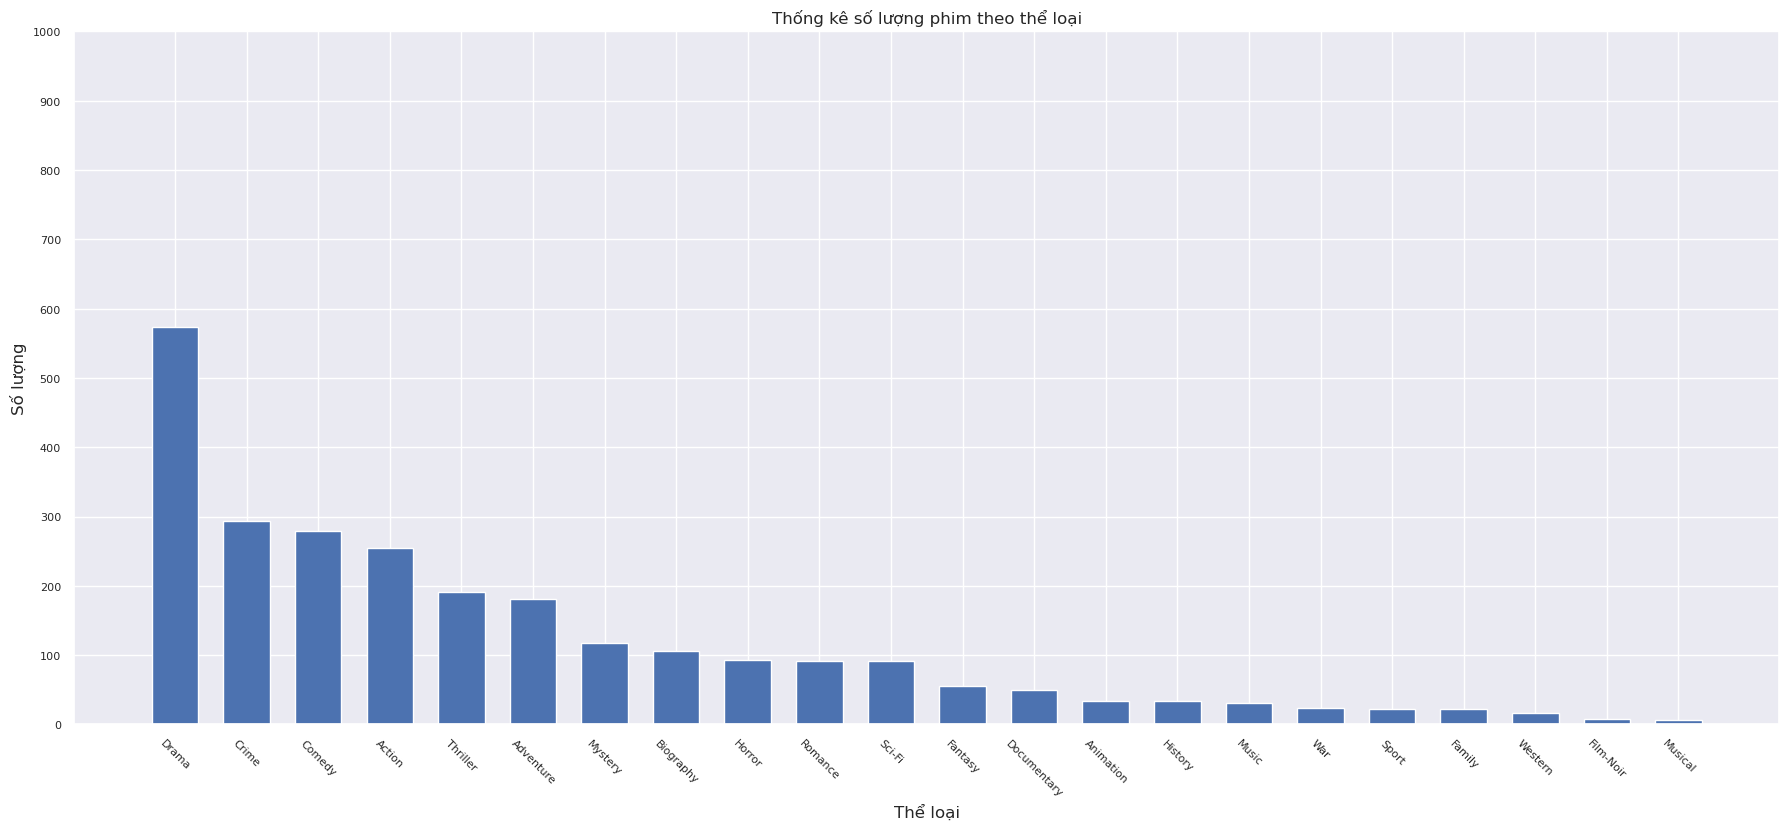

In [32]:
fig =plt.subplots(figsize=(22,9))

genre=np.array(film_genre.keys())
num_film=np.array(film_genre.values)

plt.bar(genre,num_film,width=0.65)
plt.xlabel('Thể loại')
plt.ylabel('Số lượng')
plt.title('Thống kê số lượng phim theo thể loại')
plt.xticks(genre,size=8)
plt.yticks(range(0,1001,100),size=8)
plt.setp(plt.gca().get_xticklabels(), rotation=-45, horizontalalignment='center')
plt.show()

<h4>Nhận xét:</h4>

- Nhìn biểu đồ ta thấy được xu hướng lọt top phim của các phim pha trộn(hoặc tập trung) vào thể loại drama chiếm hơn 1 nửa số lượng phim và cũng là thể loại chiếm số lượng cao nhất. Thể loại được kết hợp nhiều các yếu tố tâm lý xã hội, bi – hài tạo nên một tổng thể mang lại nhiều cảm xúc đan xen cho người xem.<br>
- Tiếp đến là các thể loại phổ biến như: phim tội phạm, hài kịch, hành động, giật gân, phiêu lưu: cũng là những thể loại chiếm đa số. Ở đây trừ hài kịch mục đích gây cười, có tính giải trí cao (*điều ai cũng cần*), thì có thể thấy gần như hầu hết đều là những thể loại mạnh mẽ, nhịp độ phim nhanh gây kích thích, hứng thú cho người xem.<br>
- Các thể loại còn lại chỉ chiếm từ 0 đến 10% số lượng phim trong danh sách.

<h3>Bước 3: Tương quan giữa thể loại phim và thập niên(Ở trên ta có giải thích qua, nên ở đây sẽ không xét thập niên 2020)</h3>

<h4>Cùng xem sự tương quan giữa thể loại phim từng thập niên như thế nào nhé</h4>

In [33]:
film_genre_decade=film_info_df[~film_info_df.Decade.isin([2020])].explode('Genres').value_counts(['Decade','Genres']).to_frame().reset_index([0,1])
film_genre_decade

,Decade,Genres,0
0,2000,Drama,169
1,1990,Drama,131
2,2010,Drama,124
3,2000,Crime,82
4,2000,Action,80
...,...,...,...
152,1960,Sport,1
153,1960,Animation,1
154,1960,Fantasy,1
155,1960,History,1


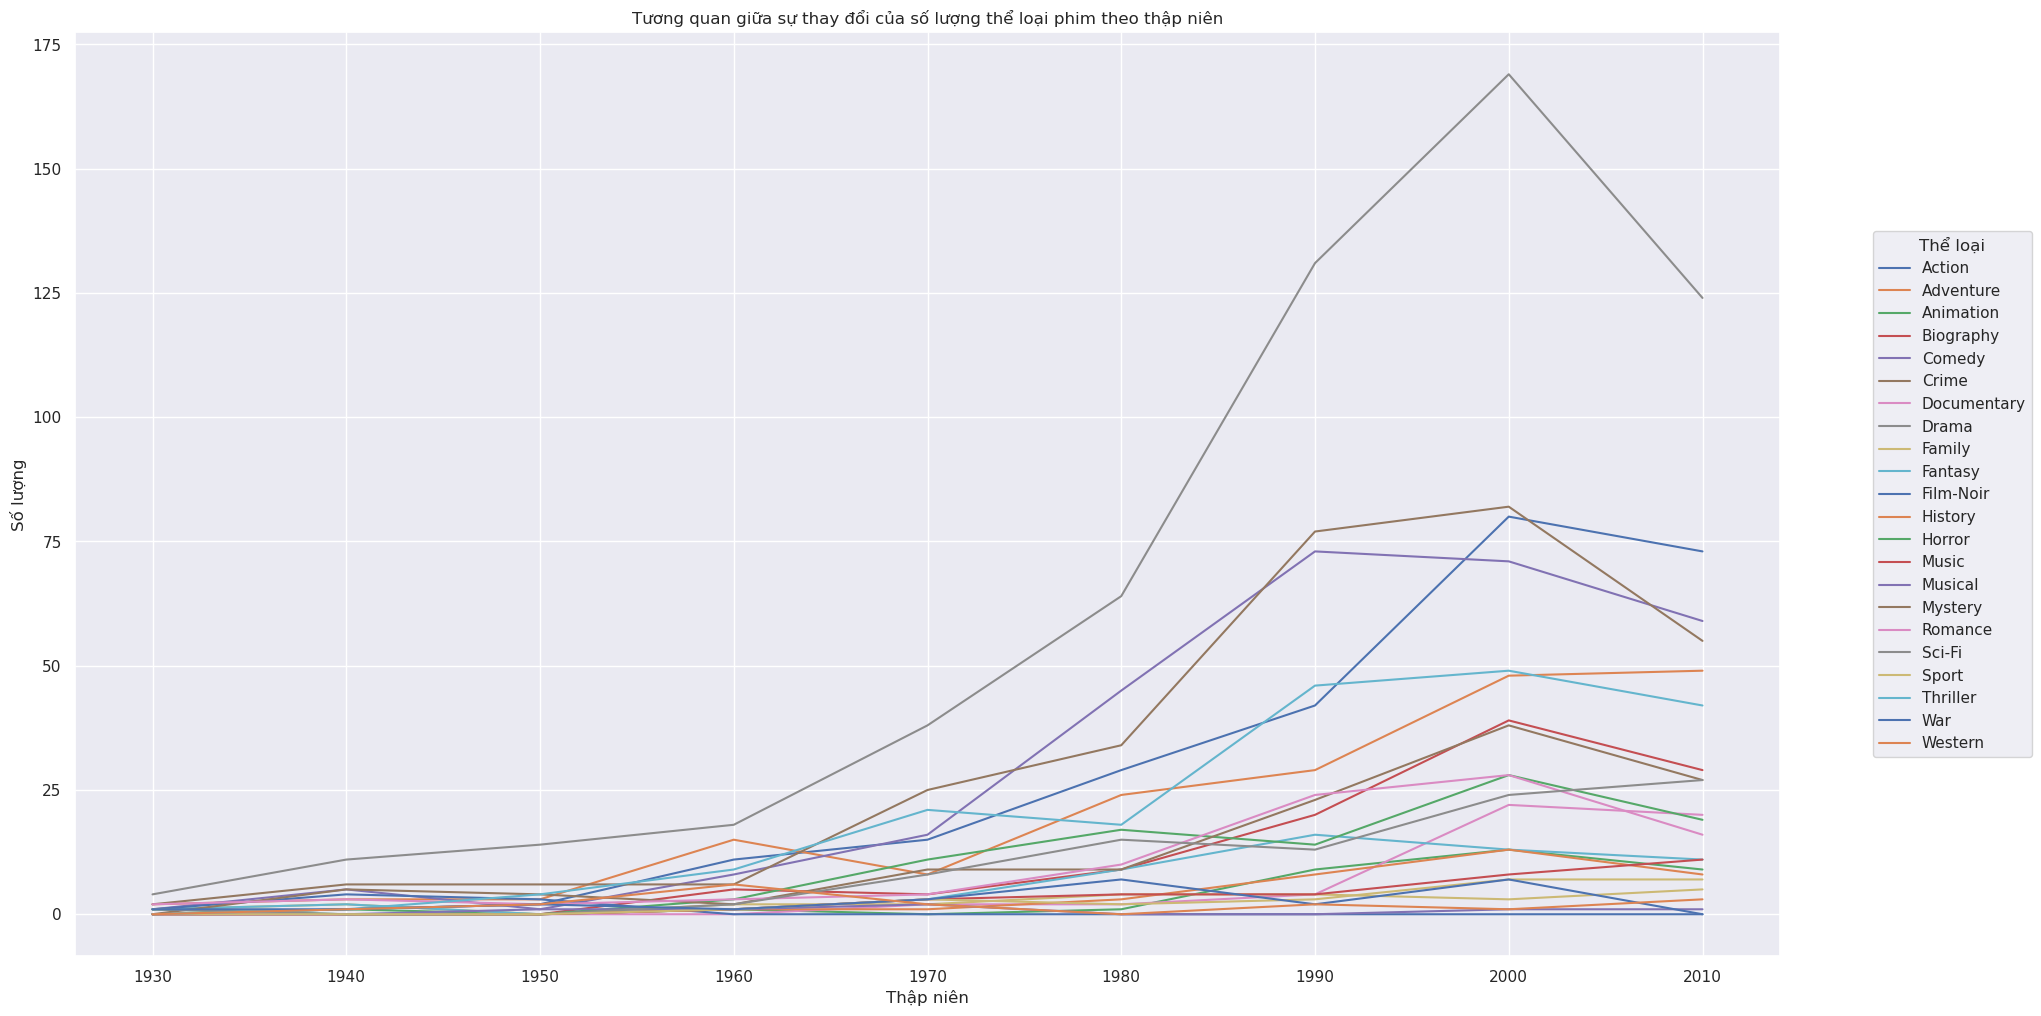

In [34]:
num_film_each_genre=film_genre_decade.pivot('Decade','Genres',0)
num_film_each_genre=num_film_each_genre.sort_index().fillna(0)

fig =plt.subplots(figsize=(22,12))

genre=np.array(film_genre.keys())
num_film=np.array(film_genre.values)

plt.plot(num_film_each_genre)
plt.xlabel('Thập niên')
plt.ylabel('Số lượng')
plt.title('Tương quan giữa sự thay đổi của số lượng thể loại phim theo thập niên')
plt.legend(num_film_each_genre.columns,title='Thể loại',loc='center left',bbox_to_anchor=(1.05,0.5))
plt.show()

<h4>Nhận xét:</h4>

- Ta thấy rằng ở thể loại Drama ở mọi thập niên đều đứng đầu trong số lượng phim lọt top.<br>
- Ở các thể loại khác có sự thay đổi theo từng thập niên(Không có sự thay đổi nhiều trong các thể loại: hành động, hài kịch, phiêu lưu, tội phạm).<br>
- Vì số lượng phim lọt top của thập niên 2010 giảm hơn 1/5 so với thập niên 2000, nên ta có thể thấy rắng chỉ vài thể loại tăng lên. Tuy rằng nhu cầu giải trí mỗi ngày càng cao, số lượng phim sản xuất cũng tăng lên và có nhiều sự khác biệt trong công nghệ làm phim.

<h3>Bước 4: Tương quan theo những chuẩn khác</h3>

<h4>Tổng doanh thu do thể loại đó mang lại</h4>

- Xử lý qua dữ liệu trước khi làm 

In [35]:
film_info_df.Gross=film_info_df.Gross.replace(np.nan,0)

In [36]:
# pd.set_option('display.max_colwidth',None)
sum_gross_genres=film_info_df.explode('Genres').groupby('Genres')['Gross'].sum().multiply(10**-7)
sum_gross_genres

Genres
Action         3123.458439
Adventure      2969.915042
Animation       522.219539
Biography       333.077834
Comedy         1795.045785
Crime          1130.544314
Documentary      50.792800
Drama          2736.377711
Family          251.515777
Fantasy         682.477792
Film-Noir         1.705491
History         145.154775
Horror          338.141635
Music           119.770309
Musical          11.823718
Mystery         543.231261
Romance         573.709122
Sci-Fi         1208.727696
Sport            65.319427
Thriller       1067.951572
War             122.148509
Western          81.141154
Name: Gross, dtype: float64

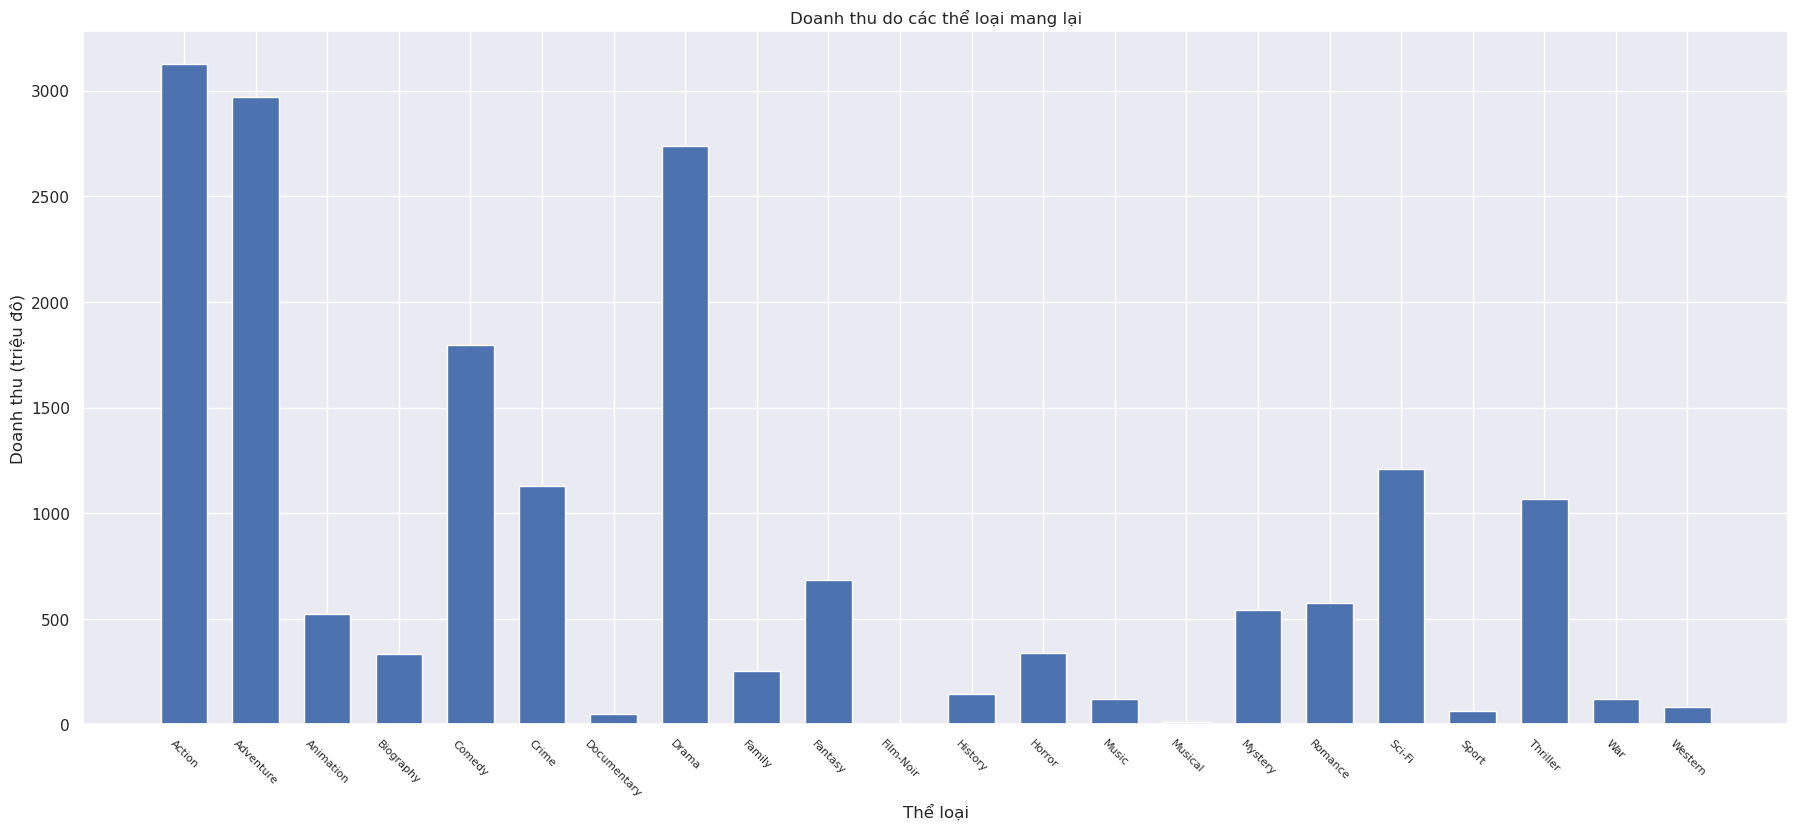

In [37]:
fig =plt.subplots(figsize=(22,9))

genre=np.array(sum_gross_genres.keys())
gross=np.array(sum_gross_genres.values)

plt.bar(genre,gross,width=0.65)
plt.xlabel('Thể loại')
plt.ylabel('Doanh thu (triệu đô)')
plt.title('Doanh thu do các thể loại mang lại')
plt.xticks(genre,size=8)
# plt.yticks(range(0,1001,100),size=8)
plt.setp(plt.gca().get_xticklabels(), rotation=-45, horizontalalignment='center')
plt.show()

<h4>Nhận xét:</h4>

- Ta thấy được doanh thu mang về của thể loại Drama vẫn không cao bằng 2 thể loại cùng đứng top là hành động và phiêu lưu.
- Biểu đồ chỉ mang tính *<b>khách quan</b>* vì có sự thay đổi của tỉ giá tiền tệ theo từng thập niên, và cũng còn một số phim chưa thể tổng hợp được tổng doanh thu.

<h4>Số lượng giải </h4>

In [38]:
film_info_df.Wins.unique()

array(['Won 3 Oscars', 'Won 1 Oscar', 'Won 2 Oscars',
       'Nominated for 1 Oscar', 'Won 7 Oscars', 'Nominated for 3 Oscars',
       'Awards', 'Nominated for 7 Oscars', 'Nominated for 4 Oscars',
       'Won 6 Oscars', 'Won 4 Oscars', 'Won 5 Oscars',
       'Won 2 BAFTA Awards', 'Won 1 BAFTA Award',
       'Nominated for 2 Oscars', 'Won 11 Oscars',
       'Nominated for 1 BAFTA Award', 'Nominated for 5 BAFTA Awards',
       'Nominated for 5 Oscars', 'Won 8 Oscars', 'Nominated for 6 Oscars',
       'Nominated for 2 BAFTA Awards', 'Nominated for 10 Oscars', None,
       'Nominated for 3 BAFTA Awards', 'Nominated for 8 Oscars',
       'Nominated for 2 Primetime Emmys',
       'Nominated for 3 Primetime Emmys', 'Won 2 Primetime Emmys',
       'Nominated for 1 Primetime Emmy'], dtype=object)

In [39]:
film_info_df.Wins.value_counts()

Awards                             421
Nominated for 1 Oscar              116
Won 1 Oscar                        106
Nominated for 2 Oscars              60
Won 2 Oscars                        47
Nominated for 3 Oscars              36
Nominated for 1 BAFTA Award         32
Won 3 Oscars                        26
Won 4 Oscars                        23
Won 1 BAFTA Award                   22
Nominated for 4 Oscars              16
Won 5 Oscars                        16
Nominated for 6 Oscars               9
Nominated for 7 Oscars               8
Won 6 Oscars                         7
Nominated for 2 BAFTA Awards         7
Nominated for 5 Oscars               7
Won 7 Oscars                         5
Won 8 Oscars                         4
Won 11 Oscars                        3
Nominated for 10 Oscars              3
Nominated for 3 BAFTA Awards         2
Won 2 BAFTA Awards                   2
Nominated for 2 Primetime Emmys      1
Nominated for 5 BAFTA Awards         1
Nominated for 3 Primetime

- Xử lý để tính được tổng số giải mà thể loại đó giành được:
    - Ta sẽ chỉ lấy những phim "Won" giải để dễ so sánh
    - Với nội dụng trong từng ô của Wins được hiểu như sau: ví dụ, won 2 oscars là thể loại đó đã thắng được 2 giải, won 11 oscars là thể loại đó thắng được 11 giải

In [40]:
film_won_awards=film_info_df[~film_info_df.Wins.str.findall(r'Won .*').explode().isnull()]
film_won_awards

,STT,ID,Name,Published Year,Decade,Rated,Duration,Genres,Director,Writers,...,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1,tt0068646,The Godfather,1972,1970,R,"[2, , hours, , 55, , minutes]","[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]",...,9.2,"$6,000,000",134966411.0,92,1849023,5.2K,193,100.0,Won 3 Oscars,/title/tt0068646/
1,2,tt0099685,Goodfellas,1990,1990,R,"[2, , hours, , 25, , minutes]","[Biography, Crime, Drama]",[Martin Scorsese],"[Martin Scorsese, Nicholas Pileggi]",...,8.7,"$25,000,000",46836394.0,194,1156616,1.5K,163,90.0,Won 1 Oscar,/title/tt0099685/
2,3,tt0110912,Pulp Fiction,1994,1990,R,"[2, , hours, , 34, , minutes]","[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]",...,8.9,"$8,000,000",107928762.0,115,2042809,3.5K,304,94.0,Won 1 Oscar,/title/tt0110912/
3,4,tt0114814,The Usual Suspects,1995,1990,R,"[1, , hour, , 46, , minutes]","[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],...,8.5,"$6,000,000",23341568.0,425,1083153,1.4K,154,77.0,Won 2 Oscars,/title/tt0114814/
4,5,tt0078788,Apocalypse Now,1979,1970,R,"[2, , hours, , 27, , minutes]","[Drama, Mystery, War]",[Francis Ford Coppola],"[John Milius, Michael Herr, Francis Ford Coppola]",...,8.5,"$31,500,000",83471511.0,307,666748,1.3K,302,94.0,Won 2 Oscars,/title/tt0078788/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,978,tt0059742,The Sound of Music,1965,1960,G,"[2, , hours, , 52, , minutes]","[Biography, Drama, Family]",[Robert Wise],"[Georg Hurdalek, Russel Crouse, Howard Lindsay]",...,8.1,"$8,200,000",163214286.0,601,235358,533,134,63.0,Won 5 Oscars,/title/tt0059742/
978,979,tt2543164,Arrival,2016,2010,PG-13,"[1, , hour, , 56, , minutes]","[Drama, Mystery, Sci-Fi]",[Denis Villeneuve],"[Ted Chiang, Eric Heisserer]",...,7.9,"$47,000,000",100546139.0,514,693818,2.2K,739,81.0,Won 1 Oscar,/title/tt2543164/
980,981,tt4034228,Manchester by the Sea,2016,2010,R,"[2, , hours, , 17, , minutes]",[Drama],[Kenneth Lonergan],[Kenneth Lonergan],...,7.8,"$9,000,000",47695371.0,"1,049",283366,931,515,96.0,Won 2 Oscars,/title/tt4034228/
981,982,tt1856101,Blade Runner 2049,2017,2010,R,"[2, , hours, , 44, , minutes]","[Action, Drama, Mystery]",[Denis Villeneuve],"[Philip K. Dick, Hampton Fancher, Michael Green]",...,8.0,"$150,000,000",92054159.0,150,570815,2.5K,564,81.0,Won 2 Oscars,/title/tt1856101/


In [41]:
genres_won_awards=film_won_awards.explode('Genres').value_counts(['Genres','Wins']).sort_index().to_frame().reset_index()
print(genres_won_awards)

def sum_awards(vl):
    # num=re.findall(r'\d*',)
    num=int(re.findall(r'\d{1,2}',str(vl))[0])
    return num

temp_count=genres_won_awards.Wins.apply(sum_awards)
genres_won_awards[0]=temp_count*genres_won_awards[0]
genres_won_awards=genres_won_awards.groupby('Genres')[0].sum()
print(genres_won_awards)

      Genres               Wins   0
0     Action  Won 1 BAFTA Award   5
1     Action        Won 1 Oscar  17
2     Action      Won 11 Oscars   1
3     Action       Won 2 Oscars  11
4     Action       Won 3 Oscars   6
..       ...                ...  ..
133      War       Won 8 Oscars   1
134  Western       Won 2 Oscars   1
135  Western       Won 3 Oscars   1
136  Western       Won 4 Oscars   1
137  Western       Won 7 Oscars   1

[138 rows x 3 columns]
Genres
Action         119
Adventure      172
Animation       26
Biography       93
Comedy         107
Crime          117
Documentary     11
Drama          488
Family          30
Fantasy         38
Film-Noir        4
History         36
Horror          11
Music           24
Musical          2
Mystery         32
Romance         92
Sci-Fi          47
Sport           11
Thriller        80
War             41
Western         16
Name: 0, dtype: int64


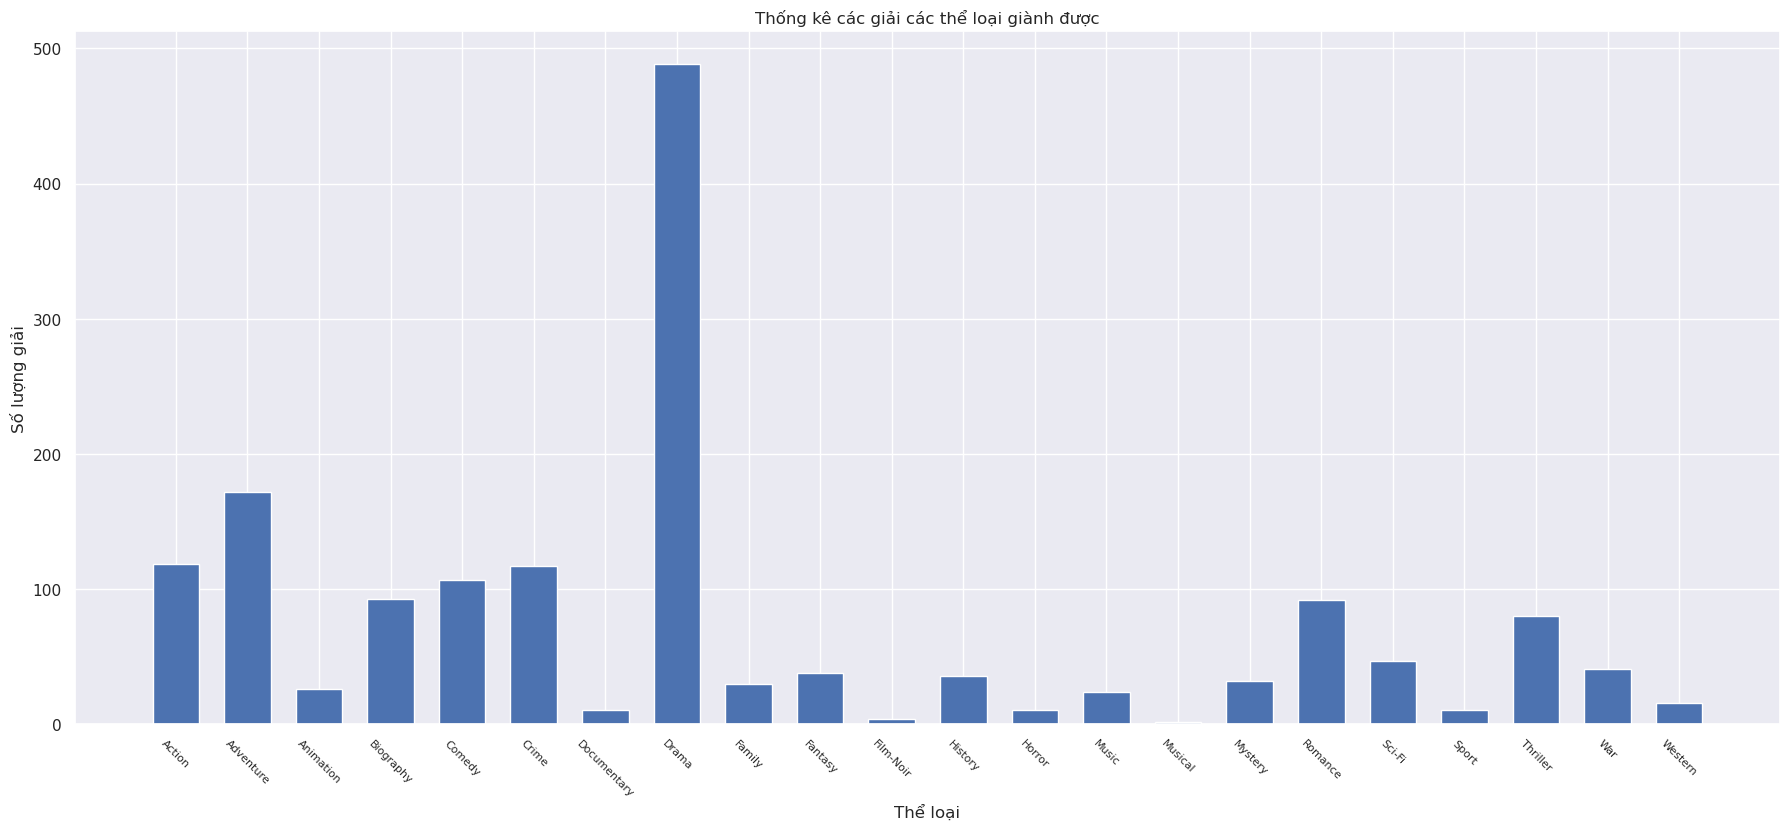

In [42]:
fig =plt.subplots(figsize=(22,9))

genre=np.array(genres_won_awards.keys())
sum_awards=np.array(genres_won_awards.values)

plt.bar(genre,sum_awards,width=0.65)
plt.xlabel('Thể loại')
plt.ylabel('Số lượng giải')
plt.title('Thống kê các giải các thể loại giành được')
plt.xticks(genre,size=8)
# plt.yticks(range(0,1001,100),size=8)
plt.setp(plt.gca().get_xticklabels(), rotation=-45, horizontalalignment='center')
plt.show()

<h4>Nhận xét:</h4>

- Nhìn vào biểu đồ trên ta đã hoàn toàn thấy sự khác biệt số lần thắng giải của thể loại Chính kịch(Drama), gấp hơn 2.5 lần so với các thể loại cùng đứng top trên.
- Qua tìm hiểu thêm trên mạng, chính kịch luôn dẫn đầu trong các thể loại được yêu thích trong các thập niên. Được giải thích như sau: 
    + Chính kịch(kết hợp giữa bi kịch và hài kịch): trong lịch sử bi kịch thường chỉ dành cho tầng lớp quý tộc, hài kịch thuộc về dân thường thấp kém, do yếu tố dung hòa giữa 2 thể loại nên phạm vi, đối tượng mà chính kịch hướng tới cũng rộng lớn hơn, đồng thời phản ánh được những câu chuyện, tính cách, tình cảm phức tạp và phong phú hơn.

    + Nhân vật trong phim chính kịch tự tạo lập cuộc sống cá nhân, đi theo ý chí bản thân, nó không chỉ biểu hiện bằng việc nỗ lực hành động để đạt được mục đích của bản thân, mà còn trải qua đấu tranh nội tâm, có ý thức tự giác, phản tư, thế giới tinh thần phong phú. Chính vì vậy, cuộc đời của nhân vật, kết cục của câu chuyện trong phim chính kịch có tính toàn vẹn hơn. Tìm được sự đồng cảm nào đó ở khán giả và nhà phê bình.

    + Phim chính kịch có nhiều phim chuyển thể từ các tiểu thuyết văn hóa lịch sử nổi tiếng.

[Tham khảo](https://filmstutamlang.wordpress.com/2016/11/25/dinh-nghia-ve-phim-chinh-kich/)

<h2>Tổng kết câu trả lời cho câu 1:</h2>
<h3>

- Thể loại được yêu thích nhất mọi thập niên: Chính kịch(Drama)
- Top các thể loại yêu thích kế tiếp *(không mang tính thứ tự - Vì mỗi thập niên có sự thay đổi qua lại vị trí giữa những thể loại đó)*: Phiêu lưu, Tội phạm, Hài kịch, Hành động
</h3>


Đưa ra câu hỏi:

1:  Phân tích trong khoảng 10 năm để tìm ra thể loại phim được ưu chuộng trong mỗi khoảng thời gian và có thể giải thích lí do:
Dựa vào việc tương quan giữa cột thể loại (genre) với lần lượt thông tin: doanh thu, lượt yêu thích (truy cập, độ nổi tiếng), điểm được chấm trên các tiêu chí khác nhau (mỗi tiêu chí là một cột).

2:  Phân tích dựa vào Top 5 – Đạo diễn xuất hiện nhiều nhất trong dataset.
Lần lượt phân tích, liệu rằng những phim của đạo diễn này sẽ trở thành trend

3:  Phân tích dựa vào Top  5 – Diễn viên xuất hiện nhiều nhất trong dataset
( Câu 2, 3 phân tích và nhận xét dựa vào câu 1)
Lần lượt phân tích, liệu rằng những phim mà diễn viên này tham gia liệu có trở thành trend

4: Chia giai đoạn phim ra mỗi 10 năm, trực quan hóa số phim mỗi giai đoạn. giải thích và nhận xét về số liệu phim mỗi giai đoạn lại có sự khác nhau.
